<a href="https://colab.research.google.com/github/tarunkv169/Products-Recommender-System-using_PySpark-OpenAI/blob/main/Machine_Learning_with_PySpark_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 1 load data with spark

In [134]:
import pandas as pd
import numpy as np

In [135]:
!pip install pyspark

In [136]:
# 1. import/create session of spark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [137]:
# 2. activate session, to use spark
spark = SparkSession.builder.appName('Product Recommander').getOrCreate()

In [138]:
# 3. use it, here our data goes to spark, where it is distributed to clusters
df = spark.read.csv('/content/products_dataset.csv', header = True, inferSchema = True, samplingRatio = 1)
# df.show()

In [139]:
df.count()

2000

#TASK 2 Now all data preprocessing--will done by---spark, as its clusters are processsing it

In [140]:
# df.show()



---



>  **i.    combined_text in one column**

---






In [141]:
# as we can see all products & details are in title and description, so concat them

# as data is in spark, but no worry--> here we r not modify, just create new--> so only use spark func to concat
from pyspark.sql.functions import concat_ws

In [142]:
df = df.withColumn('combined_text',concat_ws(" ",df.title,df.description))

In [143]:
df.count()

2000

In [144]:
# df.show()



---



>  **ii.   column--->list, to perform operations**

---






In [145]:
# here we r modifying(converting col->list), so need to use "rdd" to interact with clusters
# with "rdd" we can perform operation on data in clusters
# with "collect" we can get modified data

combined_text_list = df.select('combined_text').rdd.flatMap(lambda x : x).collect()

In [146]:
# list  contains [title[0]+description[0] , title[1]+description[1] , .....]----> ele(products) [prod1 , prod2,]
# let see few elements of list
combined_text_list[0:4]

["Men's 3X Large Carbon Heather Cotton/Polyester Rain Defender Paxton Heavyweight Hooded Zip-Front Sweatshirt This heavyweight, water-repellent hooded sweatshirt has a zip front for fast layering. ORIGINAL FIT. 13 oz., 75% cotton/25% polyester blend with Rain Defender durable water repellent. Attached, jersey-lined three-piece hood with drawcord closure. Antique-finish brass front zipper. Two front hand-warmer pockets have a hidden security pocket inside. Stretchable, spandex-reinforced rib-knit cuffs and waistband. Locker loop facilitates hanging.",
 "Turmode 30 ft. RP TNC Female to RP TNC Male Adapter Cable If you need more length between your existing wireless device and Hi-Gain Antenna, this is the product for you. It's compatible with most Wi-Fi Antennas, so it is easy for you to extend your wireless network. Just replace your existing cable that runs between your wireless device and Antenna and you're ready to use your network with extended range.",
 'Large Tapestry Bolster Bed P

In [147]:
#total ele(products) [prod1 , prod2,]
len(combined_text_list)


2000

In [148]:
# words in first ele(product)
len(combined_text_list[0].split())

70

In [149]:
len(combined_text_list[1].split())

71

In [150]:
# total words in all ele(products)
total_words = sum(len(i.split()) for i in combined_text_list)
total_words

178957



---



> **iii. Vector Embedding of the list(text--->meaningful numeric)**

---






In [151]:
# !pip install openai python-dotenv

In [152]:
# from openai import OpenAI
# from dotenv import load_dotenv

# import os

In [153]:
# # load_dotenv--> env_path---> os,
# load_dotenv(dotenv_path = '/content/apikey.env.txt')

# # from os--->extract env private creds
# APIKEY = os.getenv('APIKEY')

# # create instance of openai
# client = OpenAI(
#     api_key = APIKEY
# )


In [154]:
##using particular model of openai to embedd, and  , select dims(cols in which data spreadout)->data will equal divide in no. of cols
# response = client.embeddings.create(
#     input = combined_text_list[0:5],
#     model = 'text-embedding-3-small',
#     dimensions = 5
# )

# response

In [155]:
!pip install -U sentence-transformers

In [156]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(combined_text_list)

In [157]:
embeddings.size

768000

In [158]:
type(embeddings)

numpy.ndarray

In [159]:
# combined_text_list[0]

In [160]:
# embeddings[0]

In [161]:
len(embeddings[0])

384



---



> **iv. Inserting this embedding into our original df__ in its format**

---






creating same format(dataframe) of embedding vector of orig df **bold text** **bold text**

In [162]:
features_col_names = [f'embedding_{i}' for i in range(len(embeddings[0]))]

In [163]:
# features_col_names

In [164]:
embedding_df = spark.createDataFrame(embeddings, schema = features_col_names)
# embedding_df.show()

Exception ignored in: <function JavaWrapper.__del__ at 0x7ba89c0a2fc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'PCA' object has no attribute '_java_obj'


add a unique cols to both " embedding_df and orig df " on basis of which we join

In [165]:
embedding_df = embedding_df.repartition(1).withColumn('uniq_row',F.monotonically_increasing_id())
df = df.repartition(1).withColumn('uniq_row',F.monotonically_increasing_id())

In [166]:
# embedding_df.show()

In [167]:
# df.show()

In [168]:
df = df.join(embedding_df, on = 'uniq_row',how="inner").drop('uniq_row')
# df.show()

# TASK 3 Cluster products using kmeans



---



>  **i.** **Assemble** **all "embedding cols" into one "feature" col**

---






In [169]:
# as the data in clusters of spark,___so need of spark Assembler to assembler them in clusters
from pyspark.ml.feature import VectorAssembler

# create instance by telling what to do(in its format)
assembler = VectorAssembler(inputCols = features_col_names, outputCol = 'features')

# apply instance on our df
assembler_df = assembler.transform(df)

In [170]:
# assembler_df.show()

In [171]:
assembler_df = assembler_df.select('product_id','title','description','combined_text','features')
assembler_df.show()

+----------+--------------------+--------------------+--------------------+--------------------+
|product_id|               title|         description|       combined_text|            features|
+----------+--------------------+--------------------+--------------------+--------------------+
|        P0|Men's 3X Large Ca...|This heavyweight,...|Men's 3X Large Ca...|[-0.0383772663772...|
|        P1|Turmode 30 ft. RP...|If you need more ...|Turmode 30 ft. RP...|[-0.1224228292703...|
|        P2|Large Tapestry Bo...|Polyester cover r...|Large Tapestry Bo...|[-0.0017703186022...|
|        P3|16-Gauge-Sinks Ve...|It features a rec...|16-Gauge-Sinks Ve...|[-0.0025794846005...|
|        P4|Men's Crazy Horse...|This 9 in. black ...|Men's Crazy Horse...|[-0.0597802437841...|
|        P5|Mariana 6 ft. Mul...|With robust struc...|Mariana 6 ft. Mul...|[-0.0525395274162...|
|        P6|5 gal. #650C-2 Po...|BEHR PRO i300 Sem...|5 gal. #650C-2 Po...|[-0.0842302292585...|
|        P7|7/8 in. x 4-1/2 i.



---



> **ii. Applying k-means clustering**

---






Elbow method--> checking how many clusters neededd

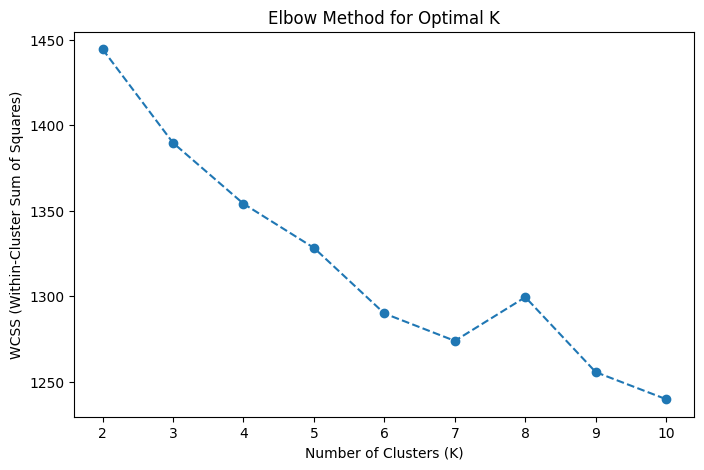

In [172]:
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

x_df = assembler_df.select("features")

wcss = []  # Store cost for each K value

for k in range(2, 11):  # Try different values of K from 2 to 10
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(x_df)
    wcss.append(model.summary.trainingCost)  # Append the cost function value

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.show()



In [173]:
# K = 6 or 7 seems to be the best choice since the rate of decrease slows down significantly after this point.
# There's no very sharp elbow, but around K=6 or K=7, the WCSS reduction flattens.

Silhouette_score--> for verifying , high score is best

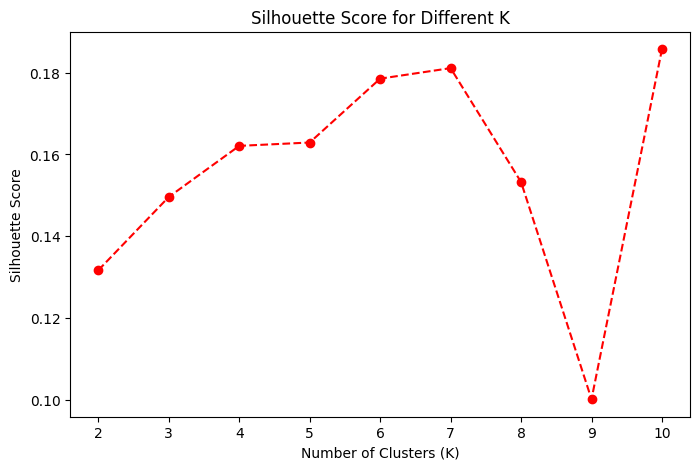

In [174]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(x_df)
    predictions = model.transform(x_df)
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker="o", linestyle="--", color="red")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different K")
plt.show()




1.   so, we can see " **in elbow 6 is flat**
2.   **in silhte 6,8 is also high** "
3.   we will use ------>  ** 6 **



In [175]:
# create instance by feeding all details
kmeans = KMeans(k=6, featuresCol = 'features' , predictionCol = 'cluster')

model = kmeans.fit(assembler_df)
clustered_data = model.transform(assembler_df)
clustered_data.show()

+----------+--------------------+--------------------+--------------------+--------------------+-------+
|product_id|               title|         description|       combined_text|            features|cluster|
+----------+--------------------+--------------------+--------------------+--------------------+-------+
|        P0|Men's 3X Large Ca...|This heavyweight,...|Men's 3X Large Ca...|[-0.0383772663772...|      4|
|        P1|Turmode 30 ft. RP...|If you need more ...|Turmode 30 ft. RP...|[-0.1224228292703...|      5|
|        P2|Large Tapestry Bo...|Polyester cover r...|Large Tapestry Bo...|[-0.0017703186022...|      4|
|        P3|16-Gauge-Sinks Ve...|It features a rec...|16-Gauge-Sinks Ve...|[-0.0025794846005...|      3|
|        P4|Men's Crazy Horse...|This 9 in. black ...|Men's Crazy Horse...|[-0.0597802437841...|      5|
|        P5|Mariana 6 ft. Mul...|With robust struc...|Mariana 6 ft. Mul...|[-0.0525395274162...|      4|
|        P6|5 gal. #650C-2 Po...|BEHR PRO i300 Sem...|5

# TASK 4 Visulaize Product clusters




---



1.  each combined_text have 384 embeddings(dimensions) i.e combined_test[0]--> have [0,1,2,....384]

2.  so its hard to visualize 384 dims
3.  we use PCA to visualize " 384-D " -->  " 2-D " , Just like in a transparent box 384 balls are in air (384-D), we are seeing only the front of box (2-D)



---



In [176]:
from pyspark.ml.feature import PCA

#Create instance of PCA by feeding details
pca = PCA(k=2,inputCol='features',outputCol='pca_features')
pca_model = pca.fit(clustered_data)
pca_results = pca_model.transform(clustered_data)

In [177]:
pca_results.show()

+----------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+
|product_id|               title|         description|       combined_text|            features|cluster|        pca_features|
+----------+--------------------+--------------------+--------------------+--------------------+-------+--------------------+
|        P0|Men's 3X Large Ca...|This heavyweight,...|Men's 3X Large Ca...|[-0.0383772663772...|      4|[0.12740703879622...|
|        P1|Turmode 30 ft. RP...|If you need more ...|Turmode 30 ft. RP...|[-0.1224228292703...|      5|[-0.0203798803551...|
|        P2|Large Tapestry Bo...|Polyester cover r...|Large Tapestry Bo...|[-0.0017703186022...|      4|[0.14052453726172...|
|        P3|16-Gauge-Sinks Ve...|It features a rec...|16-Gauge-Sinks Ve...|[-0.0025794846005...|      3|[0.01844509610692...|
|        P4|Men's Crazy Horse...|This 9 in. black ...|Men's Crazy Horse...|[-0.0597802437841...|      5|[-0.1275817924



*  

---



>  extract x and y dims from pca_features--->to visualize



---



*  









In [178]:
pca_df = pca_results.select('product_id','pca_features','cluster').toPandas()

In [179]:
pca_df

,product_id,pca_features,cluster
0,P0,"[0.12740703879622128, -0.2523959724462838]",4
1,P1,"[-0.020379880355162725, 0.05625480408216055]",5
2,P2,"[0.14052453726172104, -0.42073465495339996]",4
3,P3,"[0.018445096106929425, 0.10625132822865278]",3
4,P4,"[-0.12758179248791296, -0.16205148593212293]",5
...,...,...,...
1995,P1995,"[0.15589462303484147, -0.3038291678660307]",4
1996,P1996,"[0.1396634199790696, -0.6296858889845355]",2
1997,P1997,"[0.04534142615216209, -0.2560111974811752]",0
1998,P1998,"[0.6561779931531204, -0.04634203307049945]",1


In [180]:
pca_df['x'] = pca_df.pca_features.apply(lambda x: x[0])
pca_df['y'] = pca_df.pca_features.apply(lambda x: x[1])

In [181]:
pca_df

,product_id,pca_features,cluster,x,y
0,P0,"[0.12740703879622128, -0.2523959724462838]",4,0.127407,-0.252396
1,P1,"[-0.020379880355162725, 0.05625480408216055]",5,-0.020380,0.056255
2,P2,"[0.14052453726172104, -0.42073465495339996]",4,0.140525,-0.420735
3,P3,"[0.018445096106929425, 0.10625132822865278]",3,0.018445,0.106251
4,P4,"[-0.12758179248791296, -0.16205148593212293]",5,-0.127582,-0.162051
...,...,...,...,...,...
1995,P1995,"[0.15589462303484147, -0.3038291678660307]",4,0.155895,-0.303829
1996,P1996,"[0.1396634199790696, -0.6296858889845355]",2,0.139663,-0.629686
1997,P1997,"[0.04534142615216209, -0.2560111974811752]",0,0.045341,-0.256011
1998,P1998,"[0.6561779931531204, -0.04634203307049945]",1,0.656178,-0.046342


In [182]:
import plotly.express as px

In [183]:
def plot_clusters(pca_df, num_clusters=5):
    """
    Plots a 2D visualization of clusters using Plotly Express.

    Parameters:
    - pca_df (DataFrame): A Pandas DataFrame containing columns 'x', 'y', and 'cluster'.
      'x' and 'y' are the 2D PCA components, and 'cluster' indicates the cluster label.
    - num_clusters (int): The number of unique clusters to display.
    - recently_viewed_df (DataFrame, optional): DataFrame with 'x' and 'y' coordinates for recently viewed products.

    This function creates an interactive scatter plot where each point is colored according to its cluster.
    Recently viewed products are marked as black crosses if provided.

    Returns:
    - fig (Figure): The Plotly figure object for the plot.
    """

    # Create the base cluster plot
    fig = px.scatter(
        pca_df,
        x='x',
        y='y',
        opacity=0.6,
        size_max=4,
        color= pca_df.cluster.astype(str),
        title='2D Visualization of Clusters with Recently Viewed Products',
        labels={'x': 'PCA Component 1', 'y': 'PCA Component 2'},
        category_orders={'cluster': list(range(num_clusters))},
        # show the product id in the tooltip
        hover_data={'product_id': True}

    )

    # Update layout to add legend title and adjust plot settings
    fig.update_layout(legend_title_text='Clusters', legend=dict(x=1, y=1), width=600, height=500)

    return fig

fig = plot_clusters(pca_df)
fig.show()

# TASK 5 Recommend the Products based on Recently viewed Products

In [184]:
recently_viewed_products = [
    'P316',
    'P333',
    'P1115',
    'P1691',
    'P1082',
    'P397',
    'P1441',
    'P1054',
]

In [185]:
print("The user has recently viewed the following products: ", recently_viewed_products)

The user has recently viewed the following products:  ['P316', 'P333', 'P1115', 'P1691', 'P1082', 'P397', 'P1441', 'P1054']




---



> **1. Check records in our clustered_data related to recently viewed products**



---



In [186]:
filtered_data = clustered_data.where(F.col('product_id').isin(recently_viewed_products))
filtered_data.show()

+----------+--------------------+--------------------+--------------------+--------------------+-------+
|product_id|               title|         description|       combined_text|            features|cluster|
+----------+--------------------+--------------------+--------------------+--------------------+-------+
|      P316|Mystic Fitz Roy B...|With its distress...|Mystic Fitz Roy B...|[0.02467826008796...|      2|
|      P333|Florida Shag Beig...|Lavish natural mo...|Florida Shag Beig...|[0.04507098346948...|      2|
|      P397|1 gal. #M250-3 Ap...|BEHR ULTRA SCUFF ...|1 gal. #M250-3 Ap...|[-0.0400581583380...|      1|
|     P1054|1 gal. #HDPG60 Mi...|The improved PPG ...|1 gal. #HDPG60 Mi...|[-0.0943634882569...|      1|
|     P1082|1 qt. #S220-7 Mol...|BEHR ULTRA SCUFF ...|1 qt. #S220-7 Mol...|[-0.0793181285262...|      1|
|     P1115|Modern Gray/Multi...|This Modern Gray/...|Modern Gray/Multi...|[0.08431105315685...|      2|
|     P1441|1 qt. #PPU6-06 Ho...|BEHR PREMIUM PLUS...|1



---



> **2. select the unique clusters, we recommend on basis of unique cluste**r(i.e similar products occur in them)



---



In [187]:
unique_clusters = filtered_data.select('cluster').distinct().rdd.flatMap(lambda x : x).collect()
unique_clusters

[2, 1]



---



> **3. extract the unique clusters(our product belong to) from whole record**



---



In [188]:
unique_cluster_data = clustered_data.filter(clustered_data.cluster.isin(unique_clusters))

In [189]:
unique_cluster_data.show()

+----------+--------------------+--------------------+--------------------+--------------------+-------+
|product_id|               title|         description|       combined_text|            features|cluster|
+----------+--------------------+--------------------+--------------------+--------------------+-------+
|        P6|5 gal. #650C-2 Po...|BEHR PRO i300 Sem...|5 gal. #650C-2 Po...|[-0.0842302292585...|      1|
|       P11|1 qt. #350F-7 Wil...|BEHR PREMIUM PLUS...|1 qt. #350F-7 Wil...|[-0.0015745830023...|      1|
|       P16|5 gal. #BL-W10 Ma...|BEHR PREMIUM PLUS...|5 gal. #BL-W10 Ma...|[-0.0677598193287...|      1|
|       P18|1 qt. #M400-5 Bab...|BEHR PREMIUM PLUS...|1 qt. #M400-5 Bab...|[-0.1190816760063...|      1|
|       P21|Whimsicle Blue Mu...|In true bohemian ...|Whimsicle Blue Mu...|[0.04355436190962...|      2|
|       P24|5-gal. #HDGO64U C...|The Glidden 5-gal...|5-gal. #HDGO64U C...|[-0.0584314018487...|      1|
|       P26|5 gal. #W-B-320 W...|BEHR ULTRA SCUFF ...|5



---



> **4. filter out the products we recently viewed from unique clusters**

---





In [190]:
unique_cluster_unviewed_products = unique_cluster_data.filter(~F.col('product_id').isin(recently_viewed_products))



---

> **5. aggregate pid's to which unique clusters it belong**
**and convert to dataframe**

---





In [191]:
recommendations = unique_cluster_unviewed_products.groupby('cluster').agg(F.collect_list('product_id').alias('recommendations'))

recommendations_df = recommendations.toPandas()

recommendations_df

,cluster,recommendations
0,1,"[P6, P11, P16, P18, P24, P26, P30, P33, P40, P..."
1,2,"[P21, P52, P71, P87, P101, P108, P119, P126, P..."




---



> **6. recommend only random 5 similar products**

---





In [192]:
recommendations_df['random_recommendations'] = recommendations_df.recommendations.apply(lambda x : np.random.choice(x,5,replace=False).tolist())


recommendations_df

,cluster,recommendations,random_recommendations
0,1,"[P6, P11, P16, P18, P24, P26, P30, P33, P40, P...","[P1042, P1968, P888, P241, P1470]"
1,2,"[P21, P52, P71, P87, P101, P108, P119, P126, P...","[P1147, P655, P262, P1707, P1654]"




---



>  **7. display products from pid**'s

---





In [193]:
# write a python function to display the recommendations
def display_recommendations(row):
  # find the title of the product in df
  product_ids = row['random_recommendations']
  cluster = row.cluster

  # Use the 'df' DataFrame instead of 'data'
  titles = df. \
          filter(df["product_id"]. \
          isin(product_ids)).select("title").collect()

  print("\n")
  print("Recommendations for Cluster:", cluster)
  for title in titles:
    print(title[0])

recommendations_df.apply(display_recommendations, axis=1)



Recommendations for Cluster: 1
1 qt. #P180-4 Guava Jelly Satin Enamel Interior Paint & Primer
1 qt. PPG1208-7 Gothic Gold Satin Interior Paint with Primer
1 gal. #200B-7 Fireglow Matte Interior Stain-Blocking Paint & Primer
5 gal. #HDGR57D Seascape Flat Interior Paint with Primer
5 gal. #HDGG31U Mountain Mist Satin Interior Paint with Primer


Recommendations for Cluster: 2
Arctic Shag Ivory 5 ft. x 8 ft. Solid Area Rug
Samba Neutral Trellis 5 ft. x 7 ft. Indoor/Outdoor Area Rug
Madrid Vintage Filigree Textured Weave Black/Khaki 5 ft. Round Indoor/Outdoor Area Rug
Durant Taupe 2 ft. 7 in. x 10 ft. Runner Rug
Jarrett White 5 ft. x 7 ft. Flatweave Indoor/Outdoor Area Rug


,0
0,None
1,None
